In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import sys

import tensorflow as tf
from tensorboard.plugins.beholder import Beholder
from collections import deque

/home/ilya/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
run = 0
tf.train.create_global_step()

<tf.Variable 'global_step:0' shape=() dtype=int64_ref>

In [3]:
env = gym.envs.make('MountainCar-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [4]:
def plot_information(policies, values, qs):
    def plot_actions(data, title):
        fig, axes = plt.subplots(2, 2, figsize=(17, 7))
        fig.suptitle(title)
        for j in range(4):
            axes.flat[j].set_title(f'Action {action_descriptions[j]}')
            image = data[:, j].reshape((4, -1))
            im = axes.flat[j].imshow(image)
        fig.colorbar(im, ax=axes.ravel().tolist())

    plot_actions(policies, 'Policies')
    plt.show()
#     plot_actions(qs, 'Q values')
#     plt.show()
    
    fig = plt.figure(figsize=(17, 4))
    plt.imshow(values.reshape((4, -1)))
    plt.title('State values')
    plt.colorbar()
    plt.show()

In [5]:
def actionImages(tensor):
    tensor = tf.transpose(tf.reshape(tensor, (4, 12, 4, 1)), perm=[2, 0, 1, 3])
    images = {}
    for key, value in action_descriptions.items():
        images[value] = tf.expand_dims(tf.gather(tensor, key), 0)
        
    return images

In [19]:
class A2C:
    def __init__(
        self,
        scope,
        state_shape,
        num_actions,
        value_learning_rate,
        policy_learning_rate,
        discount_factor,
    ):
        def relu_layer(input_layer, outputs):
            return tf.layers.dense(
                input_layer,
                outputs,
                activation=tf.nn.relu,
                kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            )

        self.scope = scope

        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, state_shape, "state")
            self.next_state = tf.placeholder(tf.float32, state_shape, "next_state")
            self.action = tf.placeholder(tf.int32, [], name="action")
            self.reward = tf.placeholder(tf.float32, [], name="reward")

            batch = tf.layers.flatten(tf.stack([self.state, self.next_state]))

            with tf.variable_scope("state_encoder"):
                enc1 = relu_layer(batch, 100)
                enc2 = relu_layer(enc1, 20)
                encoded = relu_layer(enc2, 2)

            with tf.variable_scope("value_estimator"):
                vest1 = relu_layer(encoded, 100)
                vest2 = relu_layer(vest1, 10)
                values = tf.layers.dense(
                    vest2, 1, kernel_initializer=tf.zeros_initializer()
                )
                self.value = tf.squeeze(values[0])
                self.td_target = tf.squeeze(self.reward + discount_factor * values[1])
                value_loss = tf.squared_difference(self.value, self.td_target)
                value_optimizer = tf.train.AdamOptimizer(value_learning_rate)
                self.value_train_op = value_optimizer.minimize(
                    value_loss, global_step=tf.train.get_global_step()
                )
                tf.summary.scalar("value_loss", value_loss)

            with tf.variable_scope("policy_estimator"):
                pest1 = relu_layer(tf.expand_dims(encoded[0], 0), 100)
                pest2 = relu_layer(pest1, 10)
                self.action_probs = tf.squeeze(
                    tf.layers.dense(
                        pest2,
                        env.action_space.n,
                        kernel_initializer=tf.zeros_initializer(),
                        activation=tf.nn.softmax,
                        name="pest_out",
                    )
                )
                picked_action_prob = tf.squeeze(
                    tf.gather(self.action_probs, self.action)
                )
                policy_loss = -tf.log(picked_action_prob) * self.td_target
                policy_optimizer = tf.train.AdamOptimizer(policy_learning_rate)
                self.policy_train_op = policy_optimizer.minimize(
                    policy_loss, global_step=tf.train.get_global_step()
                )
                tf.summary.scalar("policy_loss", policy_loss)

            self.summary_op = tf.summary.merge_all()

    def policy(self, state):
        sess = tf.get_default_session()
        return sess.run(self.action_probs, {self.state: state, self.next_state: state})

    def update(self, state, action, reward, next_state):
        sess = tf.get_default_session()
        summary, global_step, _, _ = sess.run(
            [
                self.summary_op,
                tf.train.get_global_step(),
                self.value_train_op,
                self.policy_train_op,
            ],
            {
                self.state: state,
                self.next_state: next_state,
                self.action: action,
                self.reward: reward,
            },
        )

        return global_step, summary


def make_copy_op(a2c, other_a2c):
    trainable = tf.trainable_variables(scope=a2c.scope)
    other_trainable = tf.trainable_variables(scope=other_a2c.scope)

    k = lambda x: x.name
    assign_op = []
    for v, other_v in zip(sorted(trainable, key=k), sorted(other_trainable, key=k)):
        assign_op.append(tf.assign(other_v, v))

    return assign_op

In [22]:
tf.reset_default_graph()
tf.train.create_global_step()
a2c_trained = A2C("train", [4, 2], 3, 0.1, 0.01, 0.9)
a2c_frozen = A2C("frozen", [4, 2], 3, 0.1, 0.01, 0.9)
copy_op = make_copy_op(a2c_trained, a2c_frozen)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(copy_op)
writer = tf.summary.FileWriter(f'summaries/{run}', tf.get_default_graph())
beholder = Beholder(f'summaries/{run}')
run += 1

In [ ]:
episode_lengths = []
total_rewards = [0]

t = 0
for i in range(400):
    state = env.reset()

    done = False
    total_reward = 0
    episode_length = 0

    history = [state]

    while not done:
        if len(history) == 4:
            action_probs = a2c_frozen.policy(history)
            action = np.random.choice(len(action_probs), p=action_probs)
        else:
            action = np.random.choice(env.action_space.n)

        state, reward, done, _ = env.step(action)
        history.append(state)

        total_reward += reward
        episode_length += 1

        if len(history) == 5:
            global_step, summary = a2c_trained.update(history[:-1], action, reward, history[1:])
            writer.add_summary(summary, global_step)
#             beholder.update(sess)
            history = history[1:]
            t += 1
            
        if t == 100:
            sess.run(copy_op)

        print(f"\rStep {episode_length} @ Episode {i} ({total_rewards[-1]})", end="")

    episode_lengths.append(episode_length)
    total_rewards.append(total_reward)

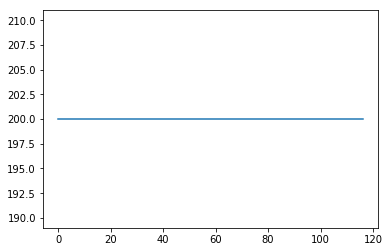

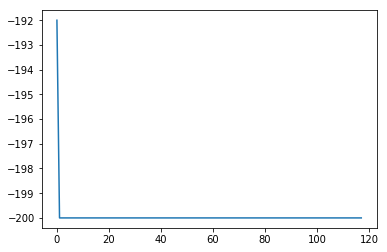

In [26]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(running_mean(episode_lengths, 25))
plt.figure()
plt.plot(running_mean(total_rewards, 25))

In [ ]:
state = env.reset()
done = False
while not done:
    action = a2c.policy(state)